# 모듈 불러오기

In [135]:
import torch
import argparse
import os
import shutil
from importlib import import_module
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np
import cv2
from torchvision import models
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import csv
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import webcolors
import torch.nn as nn
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import timm
device = "cuda" if torch.cuda.is_available() else "cpu"

In [136]:
class EfficientNet_b4(nn.Module):
    def __init__(self, class_n=5) -> None:
        super().__init__()
        self.fc = nn.Linear(1792, class_n, bias=True)
        torch.nn.init.kaiming_normal_(self.fc.weight)
        torch.nn.init.zeros_(self.fc.bias)

        self.effnetb4 = models.efficientnet_b4(pretrained=True)
        self.effnetb4.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            self.fc
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.effnetb4(x)
    
class Timm(nn.Module):
    def __init__(self, class_n=5 , model_n='efficientnet_b4'):
        super().__init__()
        self.model = timm.create_model(model_n, pretrained=True, num_classes=class_n)
        # self.dropout = nn.Dropout(0.6)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
def getModel(modeltype, device, model_n):
    if modeltype == 'timm':
        model=Timm(model_n = model_n)
    elif modeltype == 'efficientb4':
        model=EfficientNet_b4()
    
    model.to(device)
    return model

In [253]:
data_path = "/opt/ml/data/naverboostcamp_train.csv"
data = pd.read_csv(data_path)
data = data["file_name"]

In [281]:
model_path = "/opt/ml/art_cv15/output/Son_oil_512_parsing_sampler/models/Son_oil_512_parsing_sampler_best_0.50.pt"
checkpoint = torch.load(model_path).state_dict()
model = getModel("timm", "cuda", "efficientnet_b4").to(device)
model.load_state_dict(checkpoint)
target_layers = [model.model.blocks[6][1].conv_pw]

In [282]:
target_layers

[Conv2d(448, 2688, kernel_size=(1, 1), stride=(1, 1), bias=False)]

In [283]:
cam = GradCAM(model = model, target_layers = target_layers)

In [284]:
def processing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    return img

In [285]:
img = processing(cv2.imread(f"/opt/ml/data/naverboostcamp_train/JPEGImages/{data[a]}"))

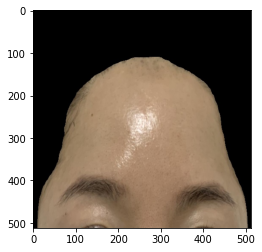

In [286]:
plt.imshow(img)

In [296]:
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).float().to(device)

In [307]:
mask = cam(input_tensor = input_tensor, targets=None)

In [308]:
grayscale_cam = mask[0, :]

In [309]:
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)

In [310]:
cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

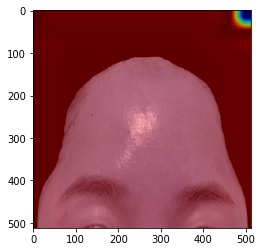

In [311]:
plt.imshow(cam_image)